In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from statsmodels.tsa import stattools
from sklearn import preprocessing
import random
import copy
import scipy
import pickle
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *
from buildsys_funcs import *

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Numerical Results

In [22]:
#initialize A, PD
A = np.array([[0.9, 0.0],
              [0.0, -0.4]])

lags = [5,10,20]
MC = 100#500
num_samps = 500

num_samps_list = np.arange(0,20,1)#[0,5,10,20,50,100]

In [23]:
mc_output_by_lag = {}

for M in lags:
    print("Lag round: ", M)
    mc_output_by_lag[M] = np.zeros((MC,3))
    for j in range(MC):
        if j % 10 == 0:
            print("Matrix initialization round: ", j)
        #B = A + randomly sample an element of A to perturb by N(0,1)
        #e = np.unravel_index(np.random.choice([i for i in range(A.shape[0]*A.shape[1])]), dims=A.shape)
        B = copy.copy(A) + np.random.normal(size=A.shape)
        #B[e] += np.random.normal(0,1)
        mc_output_by_lag[M][j,0] = np.linalg.norm(B-A,'fro')
        
        #generate a bunch of samples
        X_s = np.random.normal(size=(2,num_samps))##, size=(2,1000))
        Y_s = A.dot(X_s) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        Y_s_b = B.dot(X_s) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        
        f_bin = []
        nf_bin = []
        
        for i in range(X_s.shape[1] - M):
            #for each sample
            nf_sum = [0.0]
            f_sum = [0.0]
            

            for k in range(M):
                #collect likelihood across lag
                nf = likelihood_point(np.expand_dims(X_s[:,i+k], axis=1), np.expand_dims(Y_s[:,i+k], axis=1), A)
                f = likelihood_point(np.expand_dims(X_s[:,i+k], axis=1), np.expand_dims(Y_s_b[:,i+k], axis=1), A)

                nf_sum.append(nf_sum[-1] + nf)
                f_sum.append(f_sum[-1] + f)


            if f_sum[-1] > 0:
                f_bin.append(1)
            else:
                f_bin.append(0)

            if nf_sum[-1] > 0:
                nf_bin.append(1)
            else:
                nf_bin.append(0)
                    
        pred = np.concatenate((f_bin, nf_bin))
        true = np.concatenate((np.ones(np.asarray(f_bin).shape), np.zeros(np.asarray(nf_bin).shape)))

        p = sklearn.metrics.precision_score(true, pred)
        r = sklearn.metrics.recall_score(true, pred)
                
        mc_output_by_lag[M][j,1] = p
        mc_output_by_lag[M][j,2] = r

Lag round:  5
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Lag round:  10
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Lag round:  20
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Ma

In [24]:
for M in lags:
    print(M, ": ", np.mean(mc_output_by_lag[M], axis=0))

5 :  [1.95238667 0.80207585 0.87585859]
10 :  [1.91744725 0.84709853 0.92091837]
20 :  [1.77895363 0.90741615 0.9366875 ]


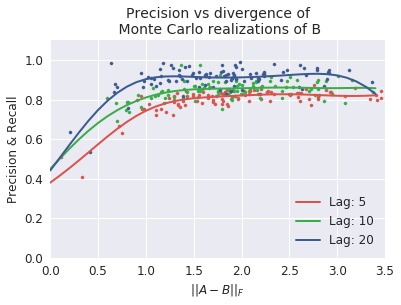

In [25]:
X_range = np.arange(0.0,3.5,0.1) 

colors=[seaborn.xkcd_rgb["pale red"], seaborn.xkcd_rgb["medium green"], seaborn.xkcd_rgb["denim blue"]]

for i in range(len(lags)):
    M = lags[i]
    color=colors[i]
    clf = None #clear previous model
    clf = KernelRidge(kernel="rbf", gamma = 1, degree=4, alpha=0.1)
    clf.fit(mc_output_by_lag[M][:,0].reshape(-1, 1), mc_output_by_lag[M][:,1].reshape(-1, 1)) 
    
    r_curve = clf.predict(X_range.reshape(-1, 1))
    r_curve[r_curve > 1] = 1
    
    plt.plot(X_range, r_curve, color=colors[i], label="Lag: " + str(M), lw=2)
    plt.scatter(mc_output_by_lag[M][:,0], mc_output_by_lag[M][:,1], marker="o", color=colors[i], s=10)

    
plt.title("Precision vs divergence of\n Monte Carlo realizations of B", fontsize=14)
plt.xlabel("$||A - B||_{F}$", fontsize=12)
plt.ylabel("Precision & Recall", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1.1)
plt.xlim(0.0,3.5)
plt.legend(loc=4, fontsize=12)
plt.show()

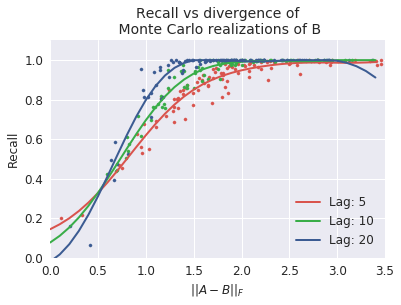

In [26]:
for i in range(len(lags)):
    M = lags[i]

    clf = None #clear previous model
    clf = KernelRidge(kernel="rbf", gamma = 1.0, degree=4, alpha=0.1)
    clf.fit(mc_output_by_lag[M][:,0].reshape(-1, 1), mc_output_by_lag[M][:,2].reshape(-1, 1)) 
    plt.scatter(mc_output_by_lag[M][:,0], mc_output_by_lag[M][:,2], marker="o", color=colors[i], s=10)
    
    r_curve = clf.predict(X_range.reshape(-1, 1))
    r_curve[r_curve > 1] = 1
    plt.plot(X_range, r_curve, color=colors[i], label="Lag: " + str(M), lw=2)
    
plt.title("Recall vs divergence of\n Monte Carlo realizations of B", fontsize=14)
plt.xlabel("$||A - B||_{F}$", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1.1)
plt.xlim(0.0,3.5)
plt.legend(loc=4, fontsize=12)
plt.show()

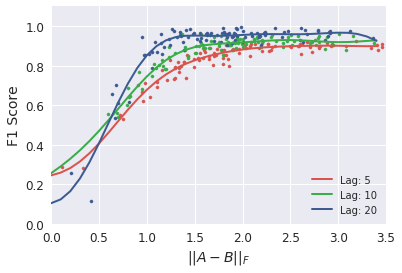

In [31]:
X_range = np.arange(0.0,3.5,0.1) 

for i in range(len(lags)):
    M = lags[i]
    clf = None #clear previous model
    clf = KernelRidge(kernel="rbf", gamma = 1, degree=7, alpha=0.01)
    f1 = 2*((mc_output_by_lag[M][:,1]*mc_output_by_lag[M][:,2])/(mc_output_by_lag[M][:,1] + mc_output_by_lag[M][:,2]))
    plt.scatter(mc_output_by_lag[M][:,0], f1, marker="o", color=colors[i], s=10)
    clf.fit(mc_output_by_lag[M][:,0].reshape(-1, 1), f1) 
    
    r_curve = clf.predict(X_range.reshape(-1, 1))
    r_curve[r_curve > 1] = 1
    
    plt.plot(X_range, r_curve, color=colors[i], label="Lag: " + str(M), lw=2)
    
#plt.title("F1 Score vs divergence of\n Monte Carlo realizations of B", fontsize=14)
plt.xlabel("$||A - B||_{F}$", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=4)
plt.ylim(0,1.1)
plt.xlim(0.0,3.5)
plt.show()

In [35]:
mc_output_by_lag_true = {}
mc_output_by_lag_est = {}
    
M = 10 #fixed lag

for N in num_samps_list:
    print("Number of training samples: ", N)
    mc_output_by_lag_true[N] = np.zeros((MC,3))
    mc_output_by_lag_est[N] = np.zeros((MC,3))
    for j in range(MC):
        if j % 10 == 0:
            print("Matrix initialization round: ", j)
        B = copy.copy(A) + np.random.normal(size=A.shape)
        
        #generate training set
        X_train = np.random.normal(size=(2,N))
        Y_train = B.dot(X_train) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(N) ]).T
        
        #generate validation set
        C = copy.copy(B) + np.random.normal(size=B.shape)
        
        X_val = np.random.normal(size=(2,num_samps))
        Y_val = B.dot(X_val) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        Y_val_f = C.dot(X_val) + np.asarray([ np.random.normal(0, np.eye(2))[:,0] for i in range(num_samps) ]).T
        
        #retrain A
        #initialize network
        params = {'FEATURE_DIM': A.shape[0], 'OUTPUT_DIM': A.shape[1]}
        net = linear_nnet(params)
        net.l1.weight.data = torch.Tensor(A)  #initialize at A

        #train linear state estimator
        if N == 0:
            B_hat = A
        else:
            train_linear_state_estimation(net, params, X_train, X_val, Y_train, Y_val, epochs=500, batch_size=N, verbose=False, validate=False)
            B_hat = net.l1.weight.data.numpy()
        
        mc_output_by_lag_true[N][j,0] = np.linalg.norm(C-B,'fro')
        mc_output_by_lag_est[N][j,0] = np.linalg.norm(C-B_hat, 'fro')
        
        f_bin_true = []
        nf_bin_true = []
        
        f_bin_est = []
        nf_bin_est = []
        
        for i in range(X_val.shape[1] - M):
            #True B
            nf_sum_true = [0.0]
            f_sum_true = [0.0]
            
            #estimated B
            nf_sum_est = [0.0]
            f_sum_est = [0.0]

            for k in range(M):
                #collect likelihood across lag: true B
                nf_true = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val[:,i+k], axis=1), B)
                f_true = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val_f[:,i+k], axis=1), B)

                nf_sum_true.append(nf_sum_true[-1] + nf_true)
                f_sum_true.append(f_sum_true[-1] + f_true)
                
                #collect likelihood across lag: estimated B
                nf_est = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val[:,i+k], axis=1), B_hat)
                f_est = likelihood_point(np.expand_dims(X_val[:,i+k], axis=1), np.expand_dims(Y_val_f[:,i+k], axis=1), B_hat)

                nf_sum_est.append(nf_sum_est[-1] + nf_est)
                f_sum_est.append(f_sum_est[-1] + f_est)

            #evaluate true B likelihoods
            if f_sum_true[-1] > 0:
                f_bin_true.append(1)
            else:
                f_bin_true.append(0)

            if nf_sum_true[-1] > 0:
                nf_bin_true.append(1)
            else:
                nf_bin_true.append(0)
                    
            pred_t = np.concatenate((f_bin_true, nf_bin_true))
            true_t = np.concatenate((np.ones(np.asarray(f_bin_true).shape), np.zeros(np.asarray(nf_bin_true).shape)))

            p_t = sklearn.metrics.precision_score(true_t, pred_t)
            r_t = sklearn.metrics.recall_score(true_t, pred_t)

            mc_output_by_lag_true[N][j,1] = p_t
            mc_output_by_lag_true[N][j,2] = r_t
            
            #evaluate estimated B likelihoods
            if f_sum_est[-1] > 0:
                f_bin_est.append(1)
            else:
                f_bin_est.append(0)

            if nf_sum_est[-1] > 0:
                nf_bin_est.append(1)
            else:
                nf_bin_est.append(0)
                    
            pred_e = np.concatenate((f_bin_est, nf_bin_est))
            true_e = np.concatenate((np.ones(np.asarray(f_bin_est).shape), np.zeros(np.asarray(nf_bin_est).shape)))

            p_e = sklearn.metrics.precision_score(true_e, pred_e)
            r_e = sklearn.metrics.recall_score(true_e, pred_e)

            mc_output_by_lag_est[N][j,1] = p_e
            mc_output_by_lag_est[N][j,2] = r_e


Number of training samples:  0
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60


/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Number of training samples:  1
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Number of training samples:  2
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initialization round:  40
Matrix initialization round:  50
Matrix initialization round:  60
Matrix initialization round:  70
Matrix initialization round:  80
Matrix initialization round:  90
Number of training samples:  3
Matrix initialization round:  0
Matrix initialization round:  10
Matrix initialization round:  20
Matrix initialization round:  30
Matrix initializati

In [36]:
div_B_true = []
div_B_est = []

prec_B_true = []
prec_B_est = []

rec_B_true = []
rec_B_est = []

for N in num_samps_list:
    print("Number of training samples: ", N)
    print("True B: ", np.mean(mc_output_by_lag_true[N], axis=0))
    print("Est B: ", np.mean(mc_output_by_lag_est[N], axis=0))
    
    div_B_true.append(np.mean(mc_output_by_lag_true[N], axis=0)[0])
    prec_B_true.append(np.mean(mc_output_by_lag_true[N], axis=0)[1])
    rec_B_true.append(np.mean(mc_output_by_lag_true[N], axis=0)[2])
    
    div_B_est.append(np.mean(mc_output_by_lag_est[N], axis=0)[0])
    prec_B_est.append(np.mean(mc_output_by_lag_est[N], axis=0)[1])
    rec_B_est.append(np.mean(mc_output_by_lag_est[N], axis=0)[2])

Number of training samples:  0
True B:  [1.88725165 0.54203639 0.99314286]
Est B:  [2.72564583 0.50644035 0.96765306]
Number of training samples:  1
True B:  [1.86519847 0.55633198 0.98840816]
Est B:  [2.36292652 0.52254357 0.97767347]
Number of training samples:  2
True B:  [1.97945107 0.55341446 0.99034694]
Est B:  [2.58717148 0.53683856 0.99589796]
Number of training samples:  3
True B:  [1.94003406 0.56289367 0.988     ]
Est B:  [3.01812221 0.52045395 0.99787755]
Number of training samples:  4
True B:  [1.9015535  0.54807699 0.99330612]
Est B:  [2.5079394  0.52326627 0.99761224]
Number of training samples:  5
True B:  [1.87164534 0.54405488 0.98926531]
Est B:  [2.22611936 0.52590465 0.99706122]
Number of training samples:  6
True B:  [1.93068943 0.53413128 0.99769388]
Est B:  [2.04387499 0.51479505 0.99263265]
Number of training samples:  7
True B:  [1.86986222 0.53982204 0.99120408]
Est B:  [2.07486445 0.52412245 0.9965102 ]
Number of training samples:  8
True B:  [1.89322778 0.55

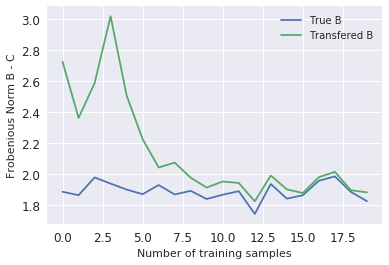

'\nplt.title("Precision vs divergence of\n Monte Carlo realizations of B", fontsize=14)\nplt.xlabel("$||A - B||_{F}$", fontsize=12)\nplt.ylabel("Precision & Recall", fontsize=12)\n\nplt.ylim(0,1.1)\nplt.xlim(0.0,3.5)\nplt.legend(loc=4, fontsize=12)\nplt.show()\n'

In [48]:
plt.plot([int(i) for i in list(num_samps_list)], div_B_true, label="True B")
plt.plot([int(i) for i in list(num_samps_list)], div_B_est, label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("Frobenious Norm B - C")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

"""
plt.title("Precision vs divergence of\n Monte Carlo realizations of B", fontsize=14)
plt.xlabel("$||A - B||_{F}$", fontsize=12)
plt.ylabel("Precision & Recall", fontsize=12)

plt.ylim(0,1.1)
plt.xlim(0.0,3.5)
plt.legend(loc=4, fontsize=12)
plt.show()
"""

[1.88725164535245,
 1.865198465352039,
 1.97945107424533,
 1.9400340595701906,
 1.9015535004549262,
 1.871645344778056,
 1.9306894252678075,
 1.869862224138613,
 1.893227776681149,
 1.840459724105269,
 1.8684403390964672,
 1.89088514276085,
 1.7446111605179178,
 1.937272723424482,
 1.8430553709884925,
 1.8647143445648573,
 1.9582250822760268,
 1.9863303892051547,
 1.8863977136423298,
 1.8267966234765527]

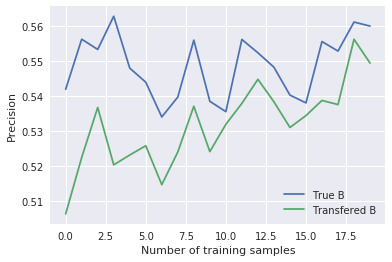

In [38]:
plt.plot(num_samps_list, prec_B_true, label="True B")
plt.plot(num_samps_list, prec_B_est, label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("Precision")
plt.show()

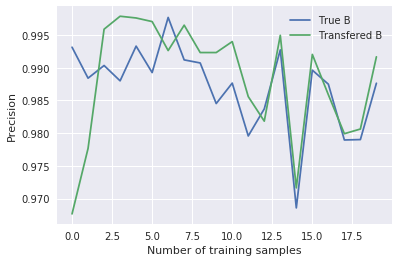

In [39]:
plt.plot(num_samps_list, rec_B_true, label="True B")
plt.plot(num_samps_list, rec_B_est, label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("Precision")
plt.show()

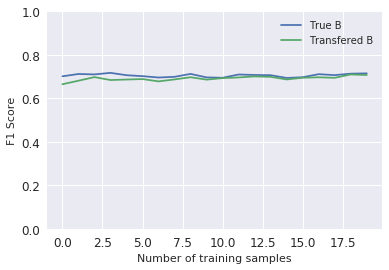

In [40]:
plt.plot(num_samps_list, 2*((np.asarray(prec_B_true)*np.asarray(rec_B_true))/(np.asarray(prec_B_true) + np.asarray(rec_B_true))), label="True B")
plt.plot(num_samps_list, 2*((np.asarray(prec_B_est)*np.asarray(rec_B_est))/(np.asarray(prec_B_est) + np.asarray(rec_B_est))), label="Transfered B")
plt.legend()
plt.xlabel("Number of training samples")
plt.ylabel("F1 Score")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1)
plt.show()

### EnergyPlus transfer from Seattle to Phoenix

In [55]:
#global vars
datapath = "../data/eplus_sims/"

#shared simulation var names
#dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
dep_var_names = ['Fans:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly']#, 'DayType']

poly_degree = 2 #5 is optimal MSE for state transition matrix A with full order 26 from cross validation and full electrical data
order = 8
lag = 140 #160

In [56]:
#Load Seattle A

seattle_net = torch.load("seattle_state_transition_net.torch")
A_seattle = copy.copy(seattle_net.l1.weight.data.numpy())

#Load Seattle classifier
with open("seattle_logreg_classifier.skl", 'rb') as d:
    logreg_seattle = pickle.load(d)

In [57]:
#Phoenix data
zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array(datapath + "refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre, Y_all_pre, X_v, Y_v = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_all, Y_all = normalize_data_set(X_all_pre, Y_all_pre, X_all_pre)

#kernelize
X_all_poly = polynomial_kernel_mat(X_all, poly_degree)

In [58]:
zone_temp_inds = [863,864,865]

Z_f, X_f, U_f = read_total_data_array(datapath + "refbuild_med_airfault/phoenix/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre_f, Y_all_pre_f, X_v_f, Y_v_f = split_train_val(Z_f, X_f, U_f, order=order, shuff=False, split_prop=1.0)
X_all_f, Y_all_f = normalize_data_set(X_all_pre_f, Y_all_pre_f, X_all_pre)

#kernelize
X_all_poly_f = polynomial_kernel_mat(X_all_f, poly_degree)

In [59]:
X, Y, X_f, Y_f = sample_classification_transform(A_seattle, X_all_poly, X_all_poly_f, Y_all, Y_all_f)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  63.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  63.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [60]:
#reformat for sklearn 

X_lag_nf = lag_samples_array(X, lag)
Y_lag_nf = np.zeros((1,X_lag_nf.shape[1]))
    
X_lag_f = lag_samples_array(X_f, lag)
Y_lag_f = np.ones((1,X_lag_f.shape[1]))
    
X_sk = np.hstack((X_lag_nf, X_lag_f))
Y_sk = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [61]:
#shuffle and train/val split

train_vals = np.random.choice(X_sk.shape[1], int(0.8*X_sk.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X_sk.shape[1]) if i not in train_vals ])

X_train_ph = X_sk[:,train_vals]
Y_train_ph = Y_sk[:,train_vals]

X_val_ph = X_sk[:,vals]
Y_val_ph = Y_sk[:,vals]

In [62]:
#use previously trained logistic regression classifier

Y_hat_val = logreg_seattle.predict(X_val_ph.T)

p = sklearn.metrics.precision_score(Y_val_ph.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_ph.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

Transfer precision:  0.4988019169329074
Transfer recall:  1.0


In [63]:
#update A and retest
transfer_prop = 0.8

X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=True, split_prop=transfer_prop)
X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
X_val, Y_val = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)

#kernelize
X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
X_val_poly = polynomial_kernel_mat(X_val, poly_degree)

#start with Seattle NN
params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
train_linear_state_estimation(seattle_net, params, X_train_poly, X_val_poly, Y_train, Y_val, epochs=1000, batch_size=100)

A_seattle = copy.copy(seattle_net.l1.weight.data.numpy())

Validation MSE:  tensor(0.0020, grad_fn=<MseLossBackward>)


In [64]:
X, Y, X_f, Y_f = sample_classification_transform(A_seattle, X_all_poly, X_all_poly_f, Y_all, Y_all_f)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  63.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  63.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [65]:
#reformat for sklearn 

X_lag_nf = lag_samples_array(X, lag)
Y_lag_nf = np.zeros((1,X_lag_nf.shape[1]))
    
X_lag_f = lag_samples_array(X_f, lag)
Y_lag_f = np.ones((1,X_lag_f.shape[1]))
    
X_sk = np.hstack((X_lag_nf, X_lag_f))
Y_sk = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [66]:
#shuffle and train/val split

train_vals = np.random.choice(X_sk.shape[1], int(transfer_prop*X_sk.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X_sk.shape[1]) if i not in train_vals ])

X_train_ph = X_sk[:,train_vals]
Y_train_ph = Y_sk[:,train_vals]

X_val_ph = X_sk[:,vals]
Y_val_ph = Y_sk[:,vals]

In [67]:
#use previously trained logistic regression classifier

Y_hat_val = logreg_seattle.predict(X_val_ph.T)

p = sklearn.metrics.precision_score(Y_val_ph.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_ph.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

Transfer precision:  0.5143769968051118
Transfer recall:  1.0


In [ ]:
#logreg_seattle.coef_
#logreg_seattle.params

In [ ]:
#transfer previous logistic regression classifier
logreg_seattle_transfer = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1, warm_start=False, solver="saga")#, n_jobs=-1, solver="saga")
logreg_seattle_transfer.coef_ = copy.copy(logreg_seattle.coef_)
logreg_seattle_transfer.fit(X_train_ph.T, Y_train_ph.T)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#test transfered classifier
Y_hat_val = logreg_seattle_transfer.predict(X_val_ph.T)

p = sklearn.metrics.precision_score(Y_val_ph.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_ph.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

In [ ]:
plot_polling_val_data(X_val_ph, Y_val_ph, logreg_seattle_transfer)

In [ ]:
Y_hat_val, Y_val_ph